## Twitter-Sentiment-Analysis

In [1]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)
stops.add(" ")
stops.add("")
# stop

### Manual Cleaning

In [3]:
def get_simple_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [4]:
lemmatizer = WordNetLemmatizer()
def clean_review(words):
    output_words = []
    for w in words:
        if w.lower() not in stops and w.isalpha():
            pos = pos_tag([w])
            clean_word = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
            output_words.append(clean_word.lower())
    return output_words

In [5]:
def data_preprocessing_text(data):
    words_in_docs = [data['text'][i].split(" ") for i in range(len(data['text']))]
    cleaned_text_data = [clean_review(words) for words in tqdm_notebook(words_in_docs)]
    text_data = [" ".join(text) for text in cleaned_text_data]
    X = [text for text in text_data]
    return X
def data_preprocessing_sentiment(data):
    return pd.DataFrame([sentiment for sentiment in data['airline_sentiment']],columns=['Sentiment'])

### Importing Dataset

In [6]:
train =  pd.read_csv('train.csv')


In [7]:
train.head()

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,568594180014014464,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)


In [8]:
train.drop('tweet_id',axis = 1, inplace = True)
train.drop('airline_sentiment_gold',axis = 1, inplace = True)
train.drop('negativereason_gold',axis = 1, inplace = True)
train.drop('tweet_coord',axis = 1, inplace = True)
train.drop('tweet_location',axis = 1, inplace = True)
train.drop('user_timezone',axis = 1, inplace = True)
train.drop('name',axis = 1, inplace = True)
train.drop('tweet_created',axis = 1, inplace = True)

In [9]:
train.head()

,airline_sentiment,airline,retweet_count,text
0,negative,Southwest,0,"@SouthwestAir I am scheduled for the morning, ..."
1,positive,Southwest,0,@SouthwestAir seeing your workers time in and ...
2,positive,United,0,@united Flew ORD to Miami and back and had gr...
3,negative,Southwest,0,@SouthwestAir @dultch97 that's horse radish 😤🐴
4,negative,United,0,@united so our flight into ORD was delayed bec...


In [10]:
oneEnc = OneHotEncoder()
data = oneEnc.fit_transform((np.array(train['airline'])).reshape(-1,1)).toarray()

In [11]:
clm = oneEnc.get_feature_names(['airline'])
one_hot_encoded_frame = pd.DataFrame(data,columns=clm)
dataset_1 = pd.concat([one_hot_encoded_frame,train],axis = 1)
# dataset_1.head()
dataset_1.shape

(10980, 10)

In [12]:
dataset_1.drop('airline',axis = 1, inplace = True)

In [13]:
def f(s):
    if s=='negative':
        return 0
    else:
        return 1

In [14]:
dataset_1['airline_sentiment'] = dataset_1['airline_sentiment'].apply(f)

In [15]:
dataset_1.head(1)

,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,airline_sentiment,retweet_count,text
0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,"@SouthwestAir I am scheduled for the morning, ..."


### Correlation Matrix Heatmap

In [16]:
cormat = dataset_1.corr()
top_corr_features = cormat.index

In [17]:
cormat

,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,airline_sentiment,retweet_count
airline_American,1.000000,-0.202382,-0.215148,-0.238544,-0.291348,-0.089718,-0.082284,-0.025832
airline_Delta,-0.202382,1.000000,-0.186531,-0.206815,-0.252596,-0.077785,0.174988,0.023579
airline_Southwest,-0.215148,-0.186531,1.000000,-0.219861,-0.268530,-0.082691,0.133430,-0.017915
airline_US Airways,-0.238544,-0.206815,-0.219861,1.000000,-0.297731,-0.091683,-0.158790,0.000546
airline_United,-0.291348,-0.252596,-0.268530,-0.297731,1.000000,-0.111979,-0.078260,0.021682
airline_Virgin America,-0.089718,-0.077785,-0.082691,-0.091683,-0.111979,1.000000,0.099889,-0.007973
airline_sentiment,-0.082284,0.174988,0.133430,-0.158790,-0.078260,0.099889,1.000000,-0.025476
retweet_count,-0.025832,0.023579,-0.017915,0.000546,0.021682,-0.007973,-0.025476,1.000000


In [18]:
dataset_1[top_corr_features].corr()

,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,airline_sentiment,retweet_count
airline_American,1.000000,-0.202382,-0.215148,-0.238544,-0.291348,-0.089718,-0.082284,-0.025832
airline_Delta,-0.202382,1.000000,-0.186531,-0.206815,-0.252596,-0.077785,0.174988,0.023579
airline_Southwest,-0.215148,-0.186531,1.000000,-0.219861,-0.268530,-0.082691,0.133430,-0.017915
airline_US Airways,-0.238544,-0.206815,-0.219861,1.000000,-0.297731,-0.091683,-0.158790,0.000546
airline_United,-0.291348,-0.252596,-0.268530,-0.297731,1.000000,-0.111979,-0.078260,0.021682
airline_Virgin America,-0.089718,-0.077785,-0.082691,-0.091683,-0.111979,1.000000,0.099889,-0.007973
airline_sentiment,-0.082284,0.174988,0.133430,-0.158790,-0.078260,0.099889,1.000000,-0.025476
retweet_count,-0.025832,0.023579,-0.017915,0.000546,0.021682,-0.007973,-0.025476,1.000000


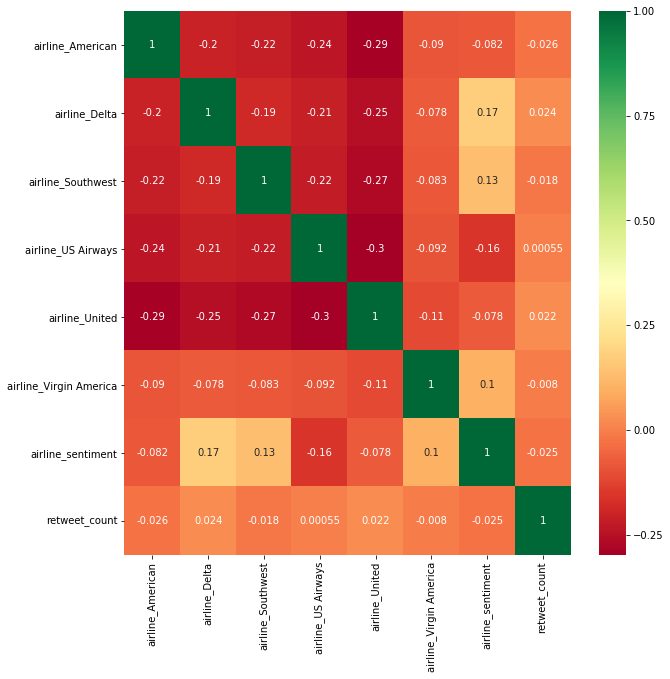

In [19]:
plt.figure(figsize=(10,10))
g = sns.heatmap(dataset_1[top_corr_features].corr(),annot=True,cmap = 'RdYlGn')

#### Text Cleaning

In [20]:
# dataset_1['text'] = data_preprocessing_text(train) 
# Use this for Manual Cleaning when using CountVectorizer instead of TfidfVectorizer

In [21]:
X = dataset_1.drop('airline_sentiment',axis = 1)
Y = data_preprocessing_sentiment(train)

In [22]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state = 0)

In [23]:
x_train.reset_index(drop = True,inplace=True)
y_train.reset_index(drop = True,inplace=True)

x_test.reset_index(drop = True,inplace=True)
y_test.reset_index(drop = True,inplace=True)


In [24]:
# Extracting Text from Training & Testing Dataset
text_train = x_train['text']
text_test = x_test['text']

### Using TfidVectorizer

In [25]:
tf_idf_vec = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words=stops, 
                             analyzer='word', max_df = 0.8, lowercase = True, use_idf = True, smooth_idf = True)

In [26]:
x_train_text_features = tf_idf_vec.fit_transform(text_train)
x_test_text_features = tf_idf_vec.transform(text_test)

In [27]:
text_features_train = pd.DataFrame(x_train_text_features.toarray(),columns=tf_idf_vec.get_feature_names())
text_features_test = pd.DataFrame(x_test_text_features.toarray(),columns=tf_idf_vec.get_feature_names())

In [28]:
x_train_new = pd.concat([x_train,text_features_train],axis = 1)
x_test_new = pd.concat([x_test,text_features_test],axis = 1)

In [29]:
x_train_new.drop('text',axis = 1, inplace = True)
x_test_new.drop('text',axis = 1, inplace = True)

In [30]:
x_train_new.head()

,airline_American,airline_Delta,airline_Southwest,airline_US Airways,airline_United,airline_Virgin America,retweet_count,00,000,000 miles,...,yet,yo,york,young,yr,yr old,yvr,yyz,zero,zone
0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Algorithms

### SVC

In [31]:
from sklearn.svm import SVC
svc = SVC(verbose=True)
svc.fit(x_train_new,y_train)
y_predicted_svc = svc.predict(x_test_new)
print("Accuracy : ",accuracy_score(y_test,y_predicted_svc))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]Accuracy :  0.6331511839708561


### Multinomial NB

In [32]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_new,y_train)
y_predicted_mNB = clf.predict(x_test_new)
print("Accuracy : ",accuracy_score(y_test,y_predicted_mNB))


Accuracy :  0.7420765027322405


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train_new,y_train)
y_predicted_dt = dt.predict(x_test_new)
print("Accuracy : ",accuracy_score(y_predicted_dt,y_test))

Accuracy :  0.66775956284153


### Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train_new,y_train)
y_predicted_rf = rf.predict(x_test_new)
print("Accuracy : ", accuracy_score(y_test,y_predicted_rf))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy :  0.7169398907103826


#### Grid Search CV on MultinomialNB

In [35]:
# To find best parameters for MultinomialNB
from sklearn.model_selection import GridSearchCV
clf_1 = MultinomialNB()
grid = {"alpha" :[0.1,0.2,0.3,0.4,0.5,0.6,0.7]}
check = GridSearchCV(clf,grid)
check.fit(x_train_new,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
check.best_estimator_

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

In [37]:
clf_updated = MultinomialNB(alpha=0.2,class_prior=None,fit_prior=True)
clf_updated.fit(x_train_new,y_train)
y_predicted_mNB = clf.predict(x_test_new)
print("Accuracy : ",accuracy_score(y_test,y_predicted_mNB))


Accuracy :  0.7420765027322405


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Comparing all the Algorithms

In [38]:
print("Random Forest Classifier : ",accuracy_score(y_test,y_predicted_rf))
print("MultinomialNB Classifier : ",accuracy_score(y_test,y_predicted_mNB))
print("Support Vector Machine Classifier : ",accuracy_score(y_test,y_predicted_svc))

Random Forest Classifier :  0.7169398907103826
MultinomialNB Classifier :  0.7420765027322405
Support Vector Machine Classifier :  0.6331511839708561


### Maximum Accuracy is achieved by MultinomialNB : 74.20%

#### Predictions

In [39]:
pred = pd.DataFrame(y_predicted_mNB)
pred.to_csv('Predictons.csv')